In [5]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import re
import seaborn as sns

## Load Files

In [6]:
# Read all columns and concatenate them into a single dataframe
df = pd.read_csv("join_df.csv", header = 0, sep="\t", index_col=0)

In [7]:
df.columns

Index(['Year Published', 'JIF', 'ISSN', 'Journal name', 'Eigenfactor',
       'Authors', 'Author Full Name', 'Document Title', 'Publication Name',
       'Author Keywords', 'Keywords Plus®', 'Abstract', 'Author Address',
       'Reprint Address', 'E-mail Address', 'ResearcherID Number', 'ORCIDs',
       'Funding Agency and Grant Number', 'Cited Reference Count',
       'Times cited', 'Usage Count (Last 180 Days)',
       'Usage Count (Since 2013)', 'Publisher', 'Publisher City',
       'Publisher Address', 'ISO Source Abbreviation', 'Publication Date',
       'Volume', 'Issue', 'Beginning Page', 'Ending Page',
       'Digital Object Identifier (DOI)', 'Page Count',
       'Web of Science Categories', 'eISSN'],
      dtype='object')

In [8]:
df.describe()

,Year Published,JIF,Eigenfactor,Cited Reference Count,Times cited,Usage Count (Last 180 Days),Usage Count (Since 2013),Page Count
count,4599.000000,4599.000000,1708.000000,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000
mean,2010.736682,4.175706,0.061004,39.363775,34.216134,0.422266,9.274407,9.462274
std,6.779574,2.655590,0.118123,17.914679,51.651986,1.172020,13.197761,3.590294
min,2000.000000,0.193000,0.001000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,2005.000000,2.531000,0.014000,27.000000,9.000000,0.000000,3.000000,7.000000
50%,2011.000000,3.694000,0.033000,37.000000,19.000000,0.000000,6.000000,9.000000
75%,2017.000000,5.204000,0.060000,48.000000,39.000000,0.000000,12.000000,11.000000
max,2022.000000,87.244000,1.540000,273.000000,833.000000,26.000000,271.000000,38.000000


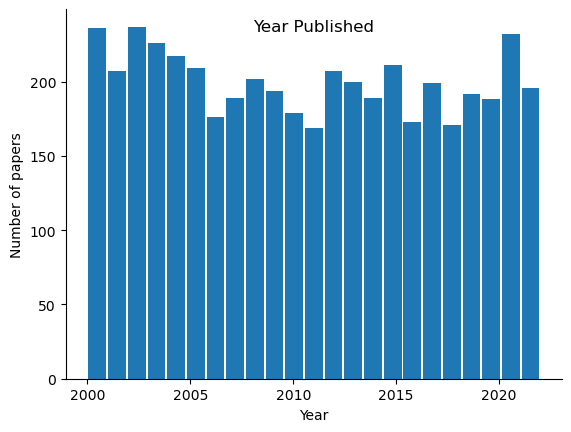

In [9]:
fig, ax = plt.subplots()
ax.hist(df['Year Published'], bins=23, rwidth=0.9)
ax.set_title('Year Published', y=1.0, pad=-16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Number of papers')
ax.set_xlabel('Year')
plt.show()

fig_path = os.path.join('.', 'report_latex', 'Images', 'year_hist.png')
fig.savefig(fig_path, dpi=100)

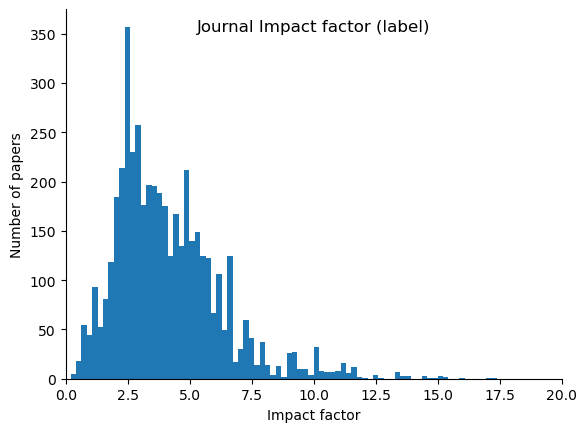

In [10]:
features = ['Year Published', 'JIF', 'Page Count', 'Times cited']
fig, ax = plt.subplots()

ax.hist(df[features[1]], bins=400)
ax.set_title('Journal Impact factor (label)', y=1.0, pad=-16)
ax.set_xlim(0,20)
ax.set_ylabel('Number of papers')
ax.set_xlabel('Impact factor')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

fig_path = os.path.join('.', 'report_latex', 'Images', 'JIF_hist.png')
fig.savefig(fig_path, dpi=100)

In [36]:
categories = df['Web of Science Categories'].apply(lambda x: x.split(';')).explode()
categories = categories.apply(lambda x: x.strip())
categories = categories.apply(lambda x: 'Chemistry' if 'Chemistry' in x else x)
categories = categories.apply(lambda x: 'Biochemistry' if 'Biochemi' in x else x)
categories = categories.apply(lambda x: 'Neurosciences' if 'Neuro' in x else x)
categories.groupby(categories).size().sort_values(ascending=False).head(10)

Web of Science Categories
Chemistry                                        1703
Pharmacology & Pharmacy                          1237
Neurosciences                                    1196
Biochemistry                                     1058
Radiology, Nuclear Medicine & Medical Imaging     998
Psychiatry                                        197
Endocrinology & Metabolism                        168
Multidisciplinary Sciences                        139
Oncology                                          112
Medicine, Research & Experimental                  89
Name: Web of Science Categories, dtype: int64

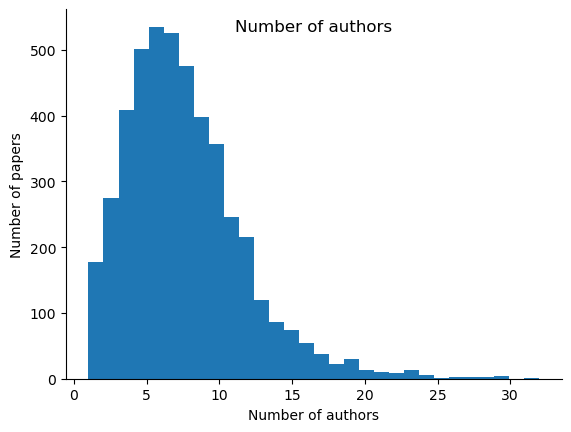

In [12]:
df['num_auth'] = df['Authors'].apply(lambda x: len(x.split(';')))
fig, ax = plt.subplots()
ax.hist(df['num_auth'], bins=30)
ax.set_title('Number of authors', y=1.0, pad=-16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Number of papers')
ax.set_xlabel('Number of authors')
plt.show()

fig_path = os.path.join('.', 'report_latex', 'Images', 'Num_auth.png')
fig.savefig(fig_path, dpi=100)

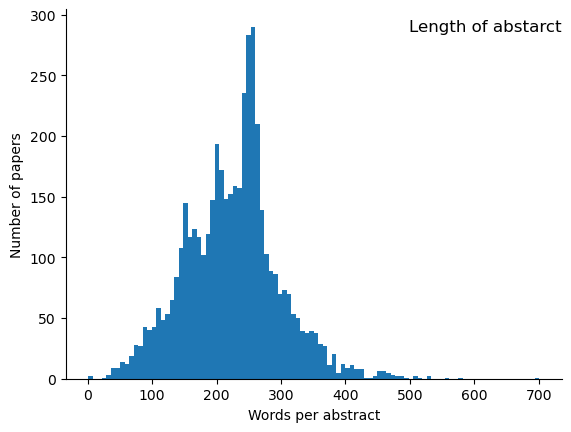

In [13]:
df['num_words'] = df['Abstract'].apply(lambda x: len(x.split(' ')))
fig, ax = plt.subplots()
ax.hist(df['num_words'], bins=100)
ax.set_title('Length of abstarct', y=1.0, loc='right', pad=-16)
ax.set_ylabel('Number of papers')
ax.set_xlabel('Words per abstract')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

fig_path = os.path.join('.', 'report_latex', 'Images', 'Abs_len.png')
fig.savefig(fig_path, dpi=100)

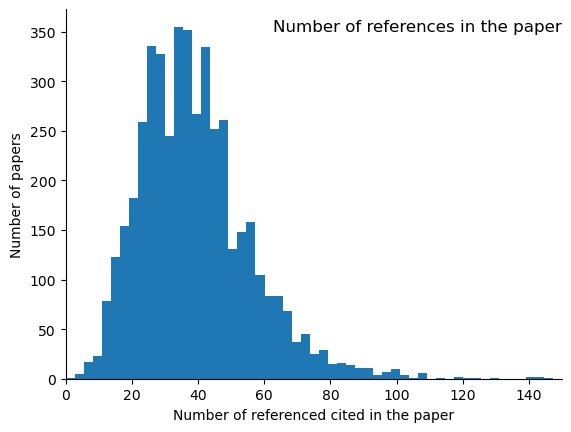

In [14]:
fig, ax = plt.subplots()
ax.hist(df['Cited Reference Count'], bins=100)
ax.set_title('Number of references in the paper', loc='right', y=1.0, pad=-16)
ax.set_xlim(0,150)
ax.set_ylabel('Number of papers')
ax.set_xlabel('Number of referenced cited in the paper')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

fig_path = os.path.join('.', 'report_latex', 'Images', 'Num_ref.png')
fig.savefig(fig_path, dpi=100)

In [15]:
def remove_authors(input_string):
    pattern = re.compile(r'\[.*?\]')
    result_string = re.sub(pattern, '  ', input_string)
    country_set = {address.split(',')[-1].strip() for address in result_string.split(';')}
    country_set_clean = set()
    for contry in country_set:
       if 'usa' in contry.lower(): country_set_clean.add('USA')
       elif 'states' in contry.lower(): country_set_clean.add('USA')
       elif 'england' in contry.lower(): country_set_clean.add('UK')
       elif 'scotland' in contry.lower(): country_set_clean.add('UK')
       elif 'china' in contry.lower(): country_set_clean.add('China')
       elif 'zech' in contry.lower(): country_set_clean.add('Czech Rep.')
       else: country_set_clean.add(contry)
    return country_set_clean

C:\Users\Artem\AppData\Local\Temp\ipykernel_15584\2966211887.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
C:\Users\Artem\AppData\Local\Temp\ipykernel_15584\2966211887.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axin.set_xticklabels(axin.get_xticklabels(), rotation = 90)
C:\Users\Artem\AppData\Local\Temp\ipykernel_15584\2966211887.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


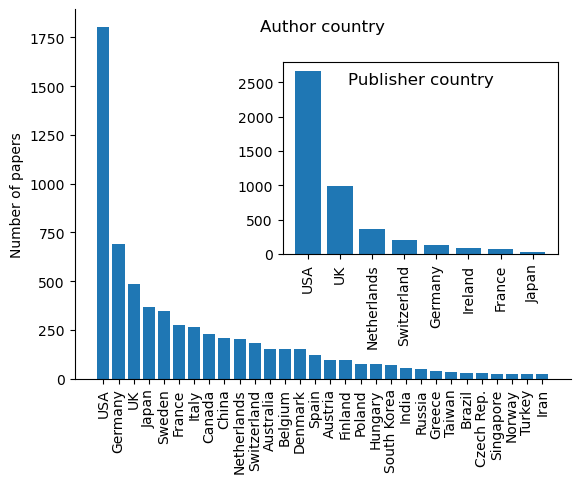

In [16]:

Auth_country_ser = df['Author Address'].astype(str).apply(lambda x: remove_authors(x)).explode()
to_plot = Auth_country_ser.groupby(Auth_country_ser).size().sort_values(ascending=False)
to_plot = to_plot[to_plot.values > 20]
fig, ax = plt.subplots()
ax.bar(x = to_plot.index, height = to_plot.values)
ax.set_title('Country of origin')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


df['Pub_country'] = df['Publisher Address'].apply(lambda x: x.split(',')[-1].split(' ')[-1].title())
df['Pub_country'] = df['Pub_country'].apply(lambda x: 'USA' if 'usa' in x.lower() else x)
df['Pub_country'] = df['Pub_country'].apply(lambda x: 'USA' if 'states' in x.lower() else x)
df['Pub_country'] = df['Pub_country'].apply(lambda x: 'UK' if 'ngland' in x.lower() else x)
df['Pub_country'] = df['Pub_country'].apply(lambda x: 'UK' if 'scotland' in x.lower() else x)
df['Pub_country'] = df['Pub_country'].apply(lambda x: 'NEW ZEALAND' if 'zealand' in x.lower() else x)
to_plot_c = df['Pub_country'].groupby(df['Pub_country']).size().sort_values(ascending=False)
to_plot_c = to_plot_c[to_plot_c.values > 20]
axin = fig.add_axes([0.45, 0.37, 0.43, 0.4])
axin.bar(x = to_plot_c.index, height = to_plot_c.values)
axin.set_xticklabels(axin.get_xticklabels(), rotation = 90)
axin.set_title('Publisher country', y=1.0, pad=-16)
ax.set_title('Author country', y=1.0, pad=-16)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_ylabel('Number of papers')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()
fig_path = os.path.join('.', 'report_latex', 'Images', 'Countries.png')
fig.savefig(fig_path, dpi=100)

In [17]:
df.columns

Index(['Year Published', 'JIF', 'ISSN', 'Journal name', 'Eigenfactor',
       'Authors', 'Author Full Name', 'Document Title', 'Publication Name',
       'Author Keywords', 'Keywords Plus®', 'Abstract', 'Author Address',
       'Reprint Address', 'E-mail Address', 'ResearcherID Number', 'ORCIDs',
       'Funding Agency and Grant Number', 'Cited Reference Count',
       'Times cited', 'Usage Count (Last 180 Days)',
       'Usage Count (Since 2013)', 'Publisher', 'Publisher City',
       'Publisher Address', 'ISO Source Abbreviation', 'Publication Date',
       'Volume', 'Issue', 'Beginning Page', 'Ending Page',
       'Digital Object Identifier (DOI)', 'Page Count',
       'Web of Science Categories', 'eISSN', 'num_auth', 'num_words',
       'Pub_country'],
      dtype='object')

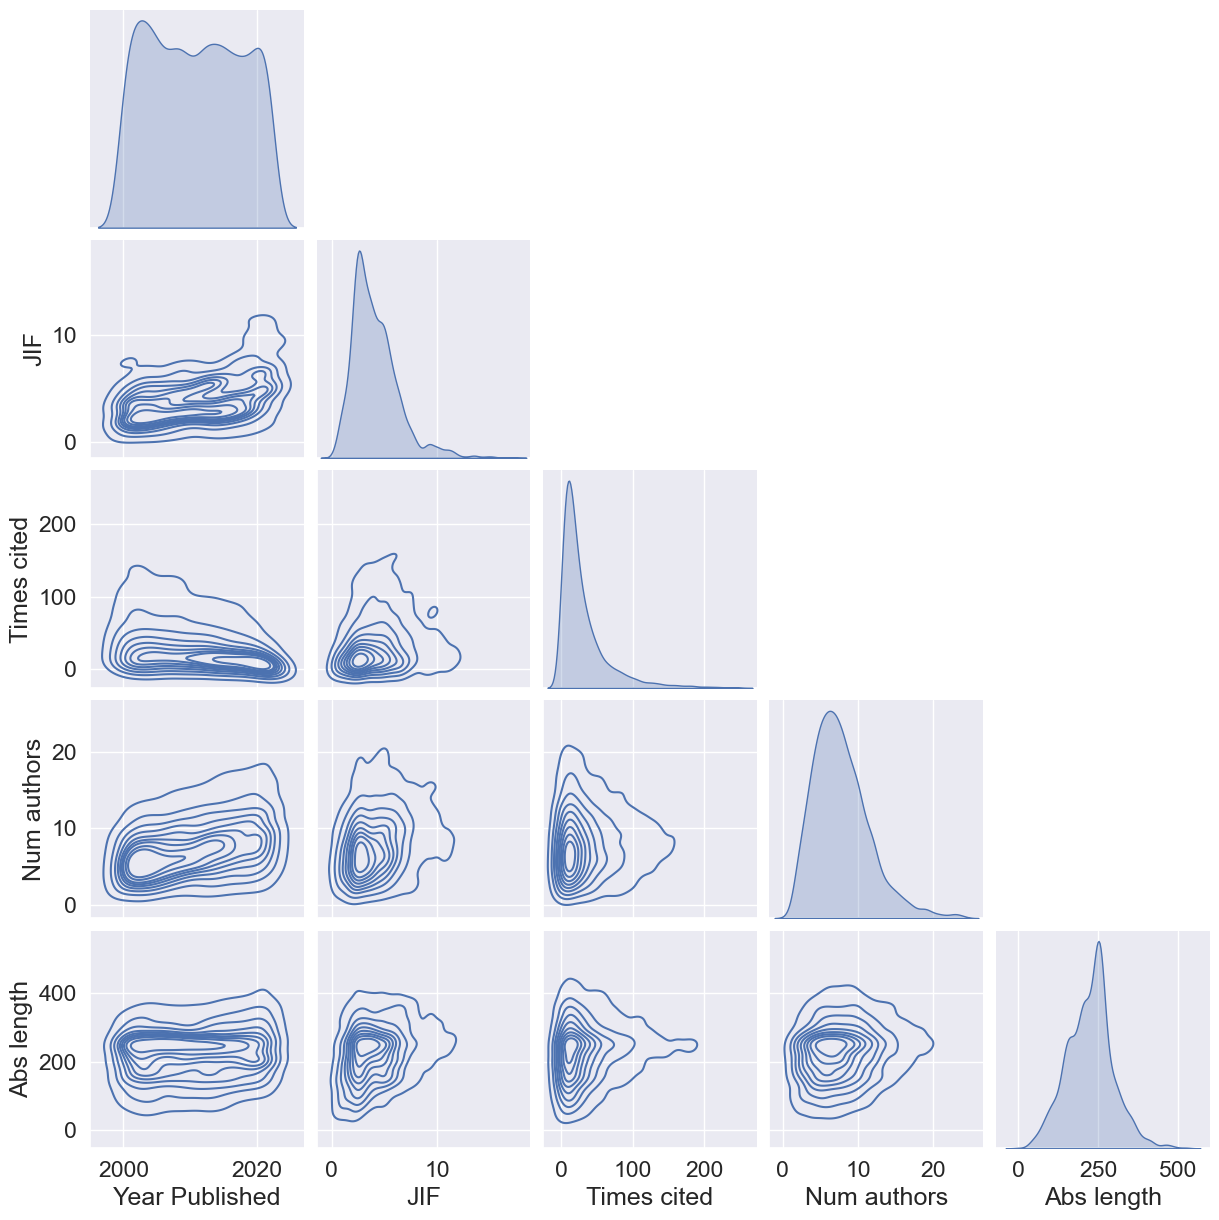

In [49]:
df_clean = df[['Year Published', 'JIF', 'Cited Reference Count', 'Times cited', 'Page Count', 'num_auth', 'num_words', 'Pub_country']]
df_clean.columns = ['Year Published', 'JIF', 'Num references', 'Times cited', 'Page Count', 'Num authors', 'Abs length', 'Pub_country']
df_clean = df_clean[df_clean['Num references']<110]
df_clean = df_clean[df_clean['JIF']<30]
df_clean = df_clean[df_clean['Abs length']<550]
df_clean = df_clean[df_clean['Num authors']<25]
df_clean = df_clean[df_clean['Times cited']<250]
sns.set(font_scale=1.5)
pairplot = sns.pairplot(df_clean[['Year Published', 'JIF', 'Times cited', 'Num authors', 'Abs length']], corner=True, kind="kde")

fig = pairplot.figure
fig_path = os.path.join('.', 'report_latex', 'Images', 'Pairplot.png')
fig.savefig(fig_path, dpi=100)
pairplot